# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import numpy as np
import moviepy
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


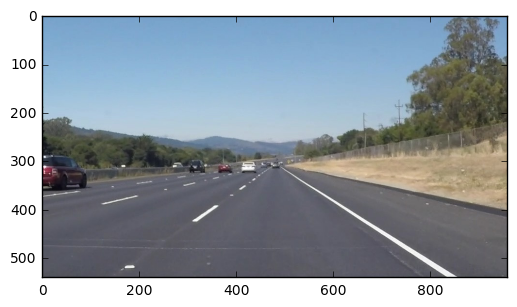

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
old_slopes_right = []
old_slopes_left = []
old_offsets_right = []
old_offsets_left = []
last_left = np.zeros(0)
last_right = np.zeros(0)

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def draw_one_line(img, line, color=[255, 0, 0], thickness=5):
    cv2.line(img, (line[1], line[0]), (line[3], line[2]), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines is not None:
        draw_lines(line_img, lines)
        return line_img, lines[:, 0]
    else:
        return line_img, lines


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, alpha=0.8, beta=0.3, sigma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, sigma)


In [5]:
## Additional functions
def compute_slopes(lines):
    slopes = []
    offsets = []
    for i in range(lines.shape[0]):
        slope = (lines[i, 3] - lines[i, 1]) / float(lines[i, 2] - lines[i, 0])
        slopes.append(slope)
        offset = lines[i, 3] - slope * lines[i, 2]
        offsets.append(offset)
    return slopes, offsets


def segment_line_groups(lines):
    slopes, dummy = compute_slopes(lines)
    positive_slope = np.asarray([slopes[i] > 0 for i in range(len(slopes))])
    # return left and right lines
    return lines[positive_slope, :], lines[np.logical_not(positive_slope), :]


def remove_outliers(lines):
    # Search for outliers in the slopes
    slopes, offsets = compute_slopes(lines)
    mean, std_dev = np.mean(slopes), np.std(slopes)
    mean2, std_dev2 = np.mean(offsets), np.std(offsets)
    inliers = np.asarray([abs(slope - mean) < std_dev and abs(offset - mean2) < std_dev2/2.0 for slope, offset in zip(slopes, offsets)])
    return lines[inliers, :]


def compute_line_segment(lines, image_height, old_offsets, old_slopes):
    # get min and max height of the lines and create a segment using the slope
    y = np.hstack((lines[:, 1], lines[:, 3]))
    x = np.hstack((lines[:, 0], lines[:, 2]))
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    if m == m and c == c:
        old_offsets.append(c)
        old_slopes.append(m)
    else:
        if len(old_slopes) == 0:
            return [0, 0, 0, 0], old_offsets, old_slopes
        else:
            m = np.mean(old_slopes)
            c = np.mean(old_offsets)
    if len(old_slopes) > 10:
        smoothed_m = np.mean((old_slopes[::-1])[:10])
        smoothed_c = np.mean((old_offsets[::-1])[:10])
    else:
        smoothed_m = np.mean(old_slopes)
        smoothed_c = np.mean(old_offsets)
    min_y, max_y = int(image_height*2/3.0), image_height
    min_x = (min_y - smoothed_c)/smoothed_m
    max_x = (max_y - smoothed_c)/smoothed_m
    segment = [min_y, min_x, max_y, max_x]
    return [int(x) for x in segment], old_offsets, old_slopes

def reset_lists():
    global old_slopes_right, old_offsets_right
    global old_slopes_left, old_offsets_left
    old_offsets_left = []
    old_slopes_left = []
    old_offsets_right = []
    old_slopes_right = []

In [6]:
## Image processing function
def process_image(image_original):
    global old_offsets_left, old_offsets_right
    global old_slopes_left, old_slopes_right
    global last_left, last_right
    image = grayscale(image_original)
    imshape = image.shape

    # FIRST APPROACH
    # Extact yellow and white colors from image and store them in the variable combined
    hsv_image = cv2.cvtColor(image_original, cv2.COLOR_BGR2HSV)
    # define range of blue and white color in HSV (Im my case due to some codec problem yellow appears as blue in cv2
    lower_blue = np.array([80, 200, 10])
    upper_blue = np.array([130, 220, 255])
    lower_white = np.array([90, 5, 210])
    upper_white = np.array([160, 30, 255])

    # Additional filtering to extract only yellow and white colors from image
    mask_yellow = cv2.inRange(hsv_image, lower_blue, upper_blue)
    mask_white = cv2.inRange(hsv_image, lower_white, upper_white)
    # combine yellow and white image
    combined = cv2.bitwise_or(mask_white, mask_yellow)
    # Dilate and erode, more iterations for erode to remove single points
    kernel = np.ones((3, 3), np.uint8)
    combined = cv2.dilate(combined, kernel, iterations=3)
    combined = cv2.erode(combined, kernel, iterations=2)

    # SECOND APPROACH
    # Classical edge detection
    blurred_image = gaussian_blur(image, 9)
    blurred_image = cv2.equalizeHist(blurred_image)
    image_edges = canny(blurred_image, 70, 200)

    # ISOLATING REGION OF INTEREST
    # region of interest for the yellow/white image
    vertices_masks = np.array([[(imshape[1]*2/13, imshape[0]),
                                (imshape[1]/2 - 20, imshape[0]*3/5),
                                (imshape[1]/2 + 20, imshape[0]*3/5),
                                (imshape[1], imshape[0])]],
                              dtype=np.int32)
    masked_image = region_of_interest(combined, vertices_masks)

    # region of interest for the edges image
    vertices_edges = np.array([[(imshape[1]*2/13, imshape[0]-70),
                                (imshape[1]/2 - 20, imshape[0]*3/5),
                                (imshape[1]/2 + 20, imshape[0]*3/5),
                                (imshape[1], imshape[0]-70)]],
                              dtype=np.int32)
    image_edges = region_of_interest(image_edges, vertices_edges)
    #cv2.imshow("canny", image_edges)

    # Detect lines separately in both images
    line_img, lines = hough_lines(image_edges, 5, np.pi * 3 / 180, 20, 20, 100)
    line_img2, lines2 = hough_lines(masked_image, 2, np.pi * 1 / 180, 50, 20, 200)
    used_lines = lines
    if lines is not None:
        if lines2 is not None:
            # Prefer lines detected from white/yellow if they exist
            # TODO select source by checking which list of detected lines has less slope variance
            used_lines = lines2
        #print "in total %s lines detected" % used_lines.shape[0]
        right, left = segment_line_groups(used_lines)
        if right.shape[0] == 0 or left.shape[0] == 0:
            used_lines = lines
            right, left = segment_line_groups(used_lines)
        try:
            left = remove_outliers(left)
            right = remove_outliers(right)
        except IndexError as e:
            print(e)

        result_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        print("%s lines on the left, %s on the right" % (left.shape[0], right.shape[0]))
        if left.shape[0] == 0:
            left = last_left
        if right.shape[0] == 0:
            right = last_right

        if left.shape[0]:
            draw_lines(result_img, np.reshape(left, (1, left.shape[0], left.shape[1])), color=[255, 0, 0])
            left_segment, old_offsets_left, old_slopes_left = compute_line_segment(left,
                                                                                   imshape[0],
                                                                                   old_offsets_left,
                                                                                   old_slopes_left)
            last_left = left
            draw_one_line(image_original, left_segment, color=[0, 255, 0])
        if right.shape[0]:
            right_segment, old_offsets_right, old_slopes_right = compute_line_segment(right,
                                                                                      imshape[0],
                                                                                      old_offsets_right,
                                                                                      old_slopes_right)
            draw_lines(result_img, np.reshape(right, (1, right.shape[0], right.shape[1])), color=[0, 255, 255])
            draw_one_line(image_original, right_segment, color=[0, 255, 0])
            last_right = right

        #cv2.imshow("final result", result_img)
        final_image = weighted_img(result_img, image_original)
        #cv2.imshow("image", final_image)
        #cv2.waitKey(1)
        return final_image
    else:
        return image_original

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

['solidYellowCurve2.jpg', 'whiteCarLaneSwitch.jpg', 'solidYellowCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowLeft.jpg', 'solidWhiteCurve.jpg']
5 lines on the left, 5 on the right
7 lines on the left, 4 on the right
2 lines on the left, 3 on the right
6 lines on the left, 8 on the right
5 lines on the left, 7 on the right
1 lines on the left, 6 on the right


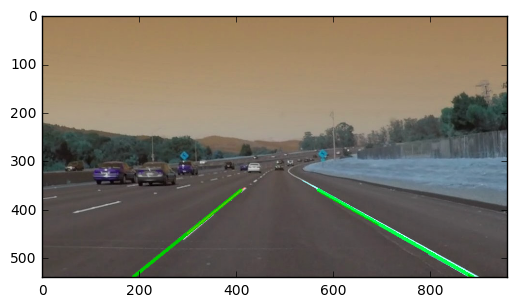

In [7]:
import os
test_images = os.listdir("test_images/")
print(test_images)
for image in test_images:
    reset_lists()
    result_image = process_image(cv2.imread("test_images/"+image))
    plt.imshow(result_image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
    reset_lists()
    white_output = 'white.mp4'
    clip1 = VideoFileClip("solidWhiteRight.mp4")
    white_clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
    white_clip.write_videofile(white_output, audio=False)

    reset_lists()
    yellow_output = 'yellow.mp4'
    clip1 = VideoFileClip("solidYellowLeft.mp4")
    white_clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
    white_clip.write_videofile(yellow_output, audio=False)

    reset_lists()
    challenge_output = 'extra.mp4'
    clip2 = VideoFileClip('challenge.mp4')
    challenge_clip = clip2.fl_image(process_image)
    challenge_clip.write_videofile(challenge_output, audio=False)

7 lines on the left, 8 on the right
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|▏         | 3/222 [00:00<00:09, 24.02it/s]

14 lines on the left, 7 on the right
7 lines on the left, 9 on the right
7 lines on the left, 13 on the right
5 lines on the left, 8 on the right
3 lines on the left, 8 on the right
2 lines on the left, 10 on the right


  4%|▍         | 9/222 [00:00<00:08, 25.59it/s]

6 lines on the left, 7 on the right
1 lines on the left, 7 on the right
11 lines on the left, 5 on the right
7 lines on the left, 5 on the right
6 lines on the left, 6 on the right


  5%|▌         | 12/222 [00:00<00:07, 26.29it/s]

10 lines on the left, 7 on the right
9 lines on the left, 12 on the right


  7%|▋         | 15/222 [00:00<00:07, 26.74it/s]

7 lines on the left, 12 on the right
4 lines on the left, 12 on the right
6 lines on the left, 6 on the right
12 lines on the left, 11 on the right


  8%|▊         | 18/222 [00:00<00:08, 25.12it/s]

6 lines on the left, 9 on the right
7 lines on the left, 17 on the right


  9%|▉         | 21/222 [00:00<00:07, 25.42it/s]

7 lines on the left, 19 on the right
8 lines on the left, 10 on the right
6 lines on the left, 15 on the right
7 lines on the left, 13 on the right


 11%|█         | 24/222 [00:00<00:07, 24.85it/s]

7 lines on the left, 13 on the right


 12%|█▏        | 27/222 [00:01<00:07, 25.39it/s]

8 lines on the left, 8 on the right
10 lines on the left, 11 on the right
6 lines on the left, 10 on the right
6 lines on the left, 6 on the right
10 lines on the left, 7 on the right
8 lines on the left, 12 on the right


 15%|█▍        | 33/222 [00:01<00:07, 25.32it/s]

9 lines on the left, 15 on the right
4 lines on the left, 15 on the right
8 lines on the left, 6 on the right
9 lines on the left, 16 on the right
4 lines on the left, 8 on the right


 16%|█▌        | 36/222 [00:01<00:07, 25.79it/s]

9 lines on the left, 6 on the right


 18%|█▊        | 39/222 [00:01<00:06, 26.24it/s]

5 lines on the left, 11 on the right
4 lines on the left, 17 on the right
6 lines on the left, 11 on the right
6 lines on the left, 12 on the right
6 lines on the left, 13 on the right


 19%|█▉        | 42/222 [00:01<00:07, 22.81it/s]

4 lines on the left, 12 on the right
1 lines on the left, 15 on the right
5 lines on the left, 14 on the right


 20%|██        | 45/222 [00:01<00:08, 20.50it/s]

10 lines on the left, 3 on the right
4 lines on the left, 11 on the right
10 lines on the left, 7 on the right
8 lines on the left, 11 on the right


 23%|██▎       | 51/222 [00:02<00:08, 19.53it/s]

9 lines on the left, 16 on the right
7 lines on the left, 13 on the right
5 lines on the left, 10 on the right
8 lines on the left, 7 on the right


 24%|██▍       | 54/222 [00:02<00:10, 16.58it/s]

2 lines on the left, 10 on the right
5 lines on the left, 15 on the right
6 lines on the left, 7 on the right


 27%|██▋       | 59/222 [00:02<00:09, 16.76it/s]

2 lines on the left, 9 on the right
3 lines on the left, 11 on the right
10 lines on the left, 8 on the right
6 lines on the left, 7 on the right
13 lines on the left, 8 on the right


 27%|██▋       | 61/222 [00:02<00:10, 15.21it/s]

7 lines on the left, 12 on the right
8 lines on the left, 6 on the right
4 lines on the left, 7 on the right


 29%|██▉       | 65/222 [00:03<00:13, 12.07it/s]

2 lines on the left, 7 on the right
4 lines on the left, 11 on the right
4 lines on the left, 11 on the right


 31%|███       | 69/222 [00:03<00:12, 12.29it/s]

5 lines on the left, 9 on the right
4 lines on the left, 10 on the right
4 lines on the left, 11 on the right


 32%|███▏      | 71/222 [00:03<00:11, 12.99it/s]

8 lines on the left, 7 on the right
4 lines on the left, 9 on the right
8 lines on the left, 10 on the right
6 lines on the left, 11 on the right


 34%|███▍      | 75/222 [00:04<00:10, 14.64it/s]

4 lines on the left, 7 on the right
4 lines on the left, 10 on the right
4 lines on the left, 9 on the right
10 lines on the left, 11 on the right


 36%|███▌      | 79/222 [00:04<00:12, 11.48it/s]

4 lines on the left, 7 on the right
5 lines on the left, 6 on the right
8 lines on the left, 3 on the right


 38%|███▊      | 84/222 [00:04<00:10, 12.63it/s]

5 lines on the left, 5 on the right
7 lines on the left, 7 on the right
10 lines on the left, 9 on the right
6 lines on the left, 7 on the right


 39%|███▊      | 86/222 [00:04<00:09, 13.67it/s]

5 lines on the left, 7 on the right
4 lines on the left, 5 on the right
0 lines on the left, 5 on the right
1 lines on the left, 2 on the right
2 lines on the left, 4 on the right


 42%|████▏     | 93/222 [00:05<00:09, 13.91it/s]

3 lines on the left, 5 on the right
5 lines on the left, 8 on the right
4 lines on the left, 9 on the right
8 lines on the left, 4 on the right


 44%|████▎     | 97/222 [00:05<00:08, 15.52it/s]

6 lines on the left, 5 on the right
4 lines on the left, 8 on the right
5 lines on the left, 5 on the right
10 lines on the left, 6 on the right


 45%|████▍     | 99/222 [00:05<00:09, 12.53it/s]

4 lines on the left, 9 on the right
9 lines on the left, 4 on the right


 45%|████▌     | 101/222 [00:06<00:09, 13.06it/s]

7 lines on the left, 8 on the right
1 lines on the left, 5 on the right
5 lines on the left, 8 on the right


 47%|████▋     | 105/222 [00:06<00:08, 13.64it/s]

5 lines on the left, 8 on the right
7 lines on the left, 8 on the right
5 lines on the left, 9 on the right
8 lines on the left, 8 on the right


 48%|████▊     | 107/222 [00:06<00:09, 12.46it/s]

8 lines on the left, 7 on the right
7 lines on the left, 6 on the right


 49%|████▉     | 109/222 [00:06<00:09, 11.32it/s]

7 lines on the left, 9 on the right
4 lines on the left, 10 on the right


 51%|█████     | 113/222 [00:07<00:09, 12.02it/s]

5 lines on the left, 11 on the right
5 lines on the left, 9 on the right
6 lines on the left, 6 on the right
9 lines on the left, 11 on the right


 53%|█████▎    | 117/222 [00:07<00:07, 14.33it/s]

6 lines on the left, 13 on the right
8 lines on the left, 7 on the right
4 lines on the left, 14 on the right
12 lines on the left, 9 on the right


 55%|█████▍    | 121/222 [00:07<00:06, 16.04it/s]

7 lines on the left, 13 on the right
10 lines on the left, 8 on the right
11 lines on the left, 7 on the right
8 lines on the left, 7 on the right
6 lines on the left, 7 on the right


 57%|█████▋    | 126/222 [00:07<00:05, 17.28it/s]

8 lines on the left, 11 on the right
3 lines on the left, 9 on the right
4 lines on the left, 2 on the right
7 lines on the left, 11 on the right


 59%|█████▊    | 130/222 [00:08<00:06, 14.88it/s]

6 lines on the left, 15 on the right
11 lines on the left, 11 on the right
5 lines on the left, 11 on the right


 59%|█████▉    | 132/222 [00:08<00:05, 15.66it/s]

5 lines on the left, 9 on the right
5 lines on the left, 5 on the right
3 lines on the left, 11 on the right
8 lines on the left, 6 on the right
5 lines on the left, 7 on the right


 62%|██████▏   | 138/222 [00:08<00:04, 17.15it/s]

5 lines on the left, 4 on the right
1 lines on the left, 6 on the right
2 lines on the left, 6 on the right
4 lines on the left, 7 on the right


 64%|██████▍   | 142/222 [00:08<00:05, 13.41it/s]

6 lines on the left, 10 on the right
5 lines on the left, 7 on the right
3 lines on the left, 13 on the right
5 lines on the left, 6 on the right


 66%|██████▌   | 146/222 [00:09<00:06, 12.25it/s]

10 lines on the left, 12 on the right
6 lines on the left, 7 on the right
11 lines on the left, 8 on the right
7 lines on the left, 16 on the right


 67%|██████▋   | 148/222 [00:09<00:06, 11.92it/s]

5 lines on the left, 14 on the right
6 lines on the left, 9 on the right
4 lines on the left, 11 on the right


 68%|██████▊   | 152/222 [00:09<00:05, 13.01it/s]

8 lines on the left, 8 on the right
5 lines on the left, 12 on the right
6 lines on the left, 13 on the right
7 lines on the left, 8 on the right


 70%|███████   | 156/222 [00:10<00:05, 12.82it/s]

6 lines on the left, 9 on the right
10 lines on the left, 8 on the right
10 lines on the left, 8 on the right
5 lines on the left, 9 on the right


 72%|███████▏  | 160/222 [00:10<00:05, 10.37it/s]

5 lines on the left, 6 on the right
7 lines on the left, 4 on the right
5 lines on the left, 13 on the right


 73%|███████▎  | 162/222 [00:10<00:05, 10.09it/s]

7 lines on the left, 3 on the right
7 lines on the left, 10 on the right
7 lines on the left, 7 on the right


 76%|███████▌  | 168/222 [00:11<00:05, 10.65it/s]

5 lines on the left, 6 on the right
8 lines on the left, 14 on the right
8 lines on the left, 5 on the right
15 lines on the left, 5 on the right
7 lines on the left, 4 on the right
9 lines on the left, 9 on the right


 77%|███████▋  | 172/222 [00:11<00:05,  8.65it/s]

3 lines on the left, 9 on the right
4 lines on the left, 7 on the right


 78%|███████▊  | 174/222 [00:12<00:05,  8.78it/s]

3 lines on the left, 10 on the right
2 lines on the left, 11 on the right


 79%|███████▉  | 176/222 [00:12<00:04,  9.49it/s]

5 lines on the left, 6 on the right
1 lines on the left, 8 on the right
2 lines on the left, 12 on the right


 81%|████████  | 180/222 [00:12<00:03, 12.47it/s]

9 lines on the left, 13 on the right
3 lines on the left, 11 on the right
5 lines on the left, 8 on the right
6 lines on the left, 7 on the right
6 lines on the left, 10 on the right


 82%|████████▏ | 183/222 [00:12<00:03, 11.34it/s]

8 lines on the left, 12 on the right


 85%|████████▍ | 188/222 [00:13<00:02, 15.24it/s]

4 lines on the left, 11 on the right
6 lines on the left, 9 on the right
10 lines on the left, 11 on the right
10 lines on the left, 13 on the right
8 lines on the left, 3 on the right
7 lines on the left, 14 on the right
7 lines on the left, 17 on the right


 87%|████████▋ | 194/222 [00:13<00:02, 13.43it/s]

8 lines on the left, 7 on the right
8 lines on the left, 8 on the right
11 lines on the left, 11 on the right
7 lines on the left, 14 on the right


 89%|████████▉ | 198/222 [00:13<00:01, 14.61it/s]

11 lines on the left, 12 on the right
8 lines on the left, 12 on the right
10 lines on the left, 11 on the right
5 lines on the left, 13 on the right


 90%|█████████ | 200/222 [00:14<00:01, 15.21it/s]

9 lines on the left, 13 on the right
12 lines on the left, 12 on the right
3 lines on the left, 11 on the right
10 lines on the left, 14 on the right
10 lines on the left, 10 on the right


 92%|█████████▏| 205/222 [00:14<00:01, 16.25it/s]

12 lines on the left, 10 on the right
9 lines on the left, 14 on the right
15 lines on the left, 14 on the right


 94%|█████████▍| 209/222 [00:14<00:00, 13.08it/s]

5 lines on the left, 12 on the right
4 lines on the left, 9 on the right
5 lines on the left, 9 on the right


 95%|█████████▌| 211/222 [00:14<00:00, 13.06it/s]

4 lines on the left, 9 on the right
4 lines on the left, 10 on the right
8 lines on the left, 8 on the right
5 lines on the left, 9 on the right
6 lines on the left, 8 on the right


 97%|█████████▋| 216/222 [00:15<00:00, 12.80it/s]

7 lines on the left, 11 on the right
4 lines on the left, 9 on the right
8 lines on the left, 16 on the right
11 lines on the left, 7 on the right


100%|█████████▉| 221/222 [00:15<00:00, 13.23it/s]

9 lines on the left, 12 on the right
5 lines on the left, 19 on the right
4 lines on the left, 13 on the right


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

5 lines on the left, 3 on the right
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 3/682 [00:00<00:29, 23.39it/s]

1 lines on the left, 6 on the right
8 lines on the left, 10 on the right
11 lines on the left, 5 on the right


  1%|          | 5/682 [00:00<00:30, 22.08it/s]

4 lines on the left, 2 on the right
2 lines on the left, 0 on the right


  1%|          | 8/682 [00:00<00:28, 23.44it/s]

2 lines on the left, 6 on the right
3 lines on the left, 4 on the right
4 lines on the left, 6 on the right


  2%|▏         | 11/682 [00:00<00:28, 23.76it/s]

5 lines on the left, 1 on the right
4 lines on the left, 2 on the right
5 lines on the left, 2 on the right


  2%|▏         | 14/682 [00:00<00:27, 24.01it/s]

4 lines on the left, 3 on the right
1 lines on the left, 6 on the right
5 lines on the left, 4 on the right
2 lines on the left, 5 on the right
5 lines on the left, 3 on the right


  2%|▏         | 17/682 [00:00<00:30, 21.83it/s]

4 lines on the left, 3 on the right
2 lines on the left, 4 on the right
5 lines on the left, 4 on the right


  3%|▎         | 20/682 [00:00<00:30, 21.70it/s]

6 lines on the left, 8 on the right
8 lines on the left, 5 on the right


  3%|▎         | 23/682 [00:01<00:31, 21.14it/s]

6 lines on the left, 4 on the right
4 lines on the left, 5 on the right


  4%|▍         | 26/682 [00:01<00:30, 21.26it/s]

3 lines on the left, 6 on the right
3 lines on the left, 8 on the right
2 lines on the left, 4 on the right


  4%|▍         | 29/682 [00:01<00:29, 22.37it/s]

2 lines on the left, 1 on the right
5 lines on the left, 8 on the right
8 lines on the left, 4 on the right
5 lines on the left, 4 on the right
6 lines on the left, 3 on the right
8 lines on the left, 5 on the right


  5%|▌         | 35/682 [00:01<00:27, 23.51it/s]

7 lines on the left, 7 on the right
7 lines on the left, 3 on the right
5 lines on the left, 2 on the right
7 lines on the left, 6 on the right
11 lines on the left, 7 on the right
10 lines on the left, 9 on the right


  6%|▌         | 38/682 [00:01<00:27, 23.82it/s]

3 lines on the left, 9 on the right
5 lines on the left, 2 on the right
0 lines on the left, 4 on the right


  6%|▌         | 41/682 [00:01<00:26, 23.99it/s]

4 lines on the left, 3 on the right
8 lines on the left, 8 on the right


  6%|▋         | 44/682 [00:01<00:31, 20.45it/s]

2 lines on the left, 7 on the right
4 lines on the left, 6 on the right
6 lines on the left, 0 on the right
8 lines on the left, 5 on the right


  7%|▋         | 47/682 [00:02<00:33, 18.69it/s]

7 lines on the left, 2 on the right
5 lines on the left, 6 on the right


  7%|▋         | 51/682 [00:02<00:34, 18.24it/s]

5 lines on the left, 7 on the right
9 lines on the left, 11 on the right


  8%|▊         | 53/682 [00:02<00:34, 17.97it/s]

9 lines on the left, 5 on the right
4 lines on the left, 6 on the right
5 lines on the left, 3 on the right
4 lines on the left, 1 on the right


  8%|▊         | 57/682 [00:02<00:50, 12.32it/s]

5 lines on the left, 4 on the right
5 lines on the left, 1 on the right
9 lines on the left, 2 on the right
8 lines on the left, 1 on the right


  9%|▊         | 59/682 [00:03<01:09,  9.01it/s]

6 lines on the left, 1 on the right


  9%|▉         | 61/682 [00:03<01:05,  9.49it/s]

6 lines on the left, 4 on the right
7 lines on the left, 3 on the right


 10%|▉         | 65/682 [00:03<00:58, 10.50it/s]

5 lines on the left, 3 on the right
7 lines on the left, 3 on the right
4 lines on the left, 4 on the right


 10%|▉         | 67/682 [00:04<01:04,  9.56it/s]

8 lines on the left, 0 on the right
16 lines on the left, 2 on the right


 10%|█         | 70/682 [00:04<00:55, 11.05it/s]

4 lines on the left, 7 on the right
9 lines on the left, 4 on the right
9 lines on the left, 6 on the right
5 lines on the left, 3 on the right


 11%|█         | 74/682 [00:04<00:46, 13.17it/s]

7 lines on the left, 4 on the right
5 lines on the left, 3 on the right
4 lines on the left, 4 on the right
3 lines on the left, 4 on the right


 11%|█         | 76/682 [00:04<00:52, 11.44it/s]

5 lines on the left, 4 on the right
6 lines on the left, 2 on the right


 11%|█▏        | 78/682 [00:04<00:52, 11.42it/s]

2 lines on the left, 5 on the right
6 lines on the left, 3 on the right
7 lines on the left, 1 on the right


 12%|█▏        | 82/682 [00:05<00:54, 11.01it/s]

9 lines on the left, 3 on the right
7 lines on the left, 1 on the right
9 lines on the left, 2 on the right
9 lines on the left, 2 on the right


 12%|█▏        | 84/682 [00:05<00:50, 11.84it/s]

10 lines on the left, 4 on the right
10 lines on the left, 2 on the right


 13%|█▎        | 88/682 [00:05<00:56, 10.55it/s]

7 lines on the left, 4 on the right
8 lines on the left, 2 on the right
11 lines on the left, 11 on the right


 13%|█▎        | 90/682 [00:06<00:51, 11.48it/s]

9 lines on the left, 4 on the right
3 lines on the left, 4 on the right
2 lines on the left, 1 on the right


 14%|█▍        | 95/682 [00:06<00:50, 11.58it/s]

4 lines on the left, 2 on the right
5 lines on the left, 2 on the right
4 lines on the left, 4 on the right
5 lines on the left, 3 on the right
9 lines on the left, 1 on the right


 15%|█▍        | 100/682 [00:06<00:42, 13.69it/s]

3 lines on the left, 2 on the right
4 lines on the left, 6 on the right
8 lines on the left, 6 on the right


 15%|█▍        | 102/682 [00:07<00:48, 11.98it/s]

2 lines on the left, 6 on the right
2 lines on the left, 3 on the right


 15%|█▌        | 104/682 [00:07<00:50, 11.38it/s]

4 lines on the left, 7 on the right
14 lines on the left, 6 on the right
3 lines on the left, 1 on the right


 16%|█▌        | 108/682 [00:07<00:45, 12.69it/s]

7 lines on the left, 3 on the right
1 lines on the left, 3 on the right
11 lines on the left, 4 on the right


 16%|█▌        | 110/682 [00:07<00:53, 10.59it/s]

2 lines on the left, 3 on the right
9 lines on the left, 2 on the right


 16%|█▋        | 112/682 [00:07<00:55, 10.26it/s]

4 lines on the left, 2 on the right
9 lines on the left, 5 on the right
6 lines on the left, 6 on the right


 17%|█▋        | 116/682 [00:08<00:45, 12.53it/s]

6 lines on the left, 6 on the right
3 lines on the left, 7 on the right
3 lines on the left, 5 on the right
4 lines on the left, 2 on the right


 17%|█▋        | 118/682 [00:08<00:43, 12.93it/s]

4 lines on the left, 1 on the right
10 lines on the left, 2 on the right
7 lines on the left, 4 on the right


 18%|█▊        | 122/682 [00:08<00:50, 11.02it/s]

8 lines on the left, 1 on the right
6 lines on the left, 2 on the right
14 lines on the left, 3 on the right
2 lines on the left, 3 on the right


 18%|█▊        | 126/682 [00:09<00:55, 10.10it/s]

5 lines on the left, 4 on the right
4 lines on the left, 5 on the right


 19%|█▉        | 130/682 [00:09<00:44, 12.41it/s]

4 lines on the left, 6 on the right
7 lines on the left, 2 on the right
7 lines on the left, 3 on the right
9 lines on the left, 0 on the right


 19%|█▉        | 132/682 [00:09<00:41, 13.28it/s]

7 lines on the left, 3 on the right
4 lines on the left, 2 on the right
4 lines on the left, 3 on the right


 20%|█▉        | 134/682 [00:09<00:44, 12.32it/s]

6 lines on the left, 1 on the right
12 lines on the left, 0 on the right


 20%|██        | 138/682 [00:10<00:46, 11.69it/s]

8 lines on the left, 3 on the right
8 lines on the left, 3 on the right
7 lines on the left, 2 on the right


 21%|██        | 140/682 [00:10<00:44, 12.10it/s]

8 lines on the left, 5 on the right
10 lines on the left, 6 on the right
8 lines on the left, 2 on the right


 21%|██        | 142/682 [00:10<00:52, 10.35it/s]

11 lines on the left, 0 on the right
5 lines on the left, 0 on the right


 21%|██        | 144/682 [00:10<00:52, 10.32it/s]

8 lines on the left, 3 on the right
7 lines on the left, 1 on the right
5 lines on the left, 3 on the right


 22%|██▏       | 148/682 [00:11<00:53, 10.00it/s]

5 lines on the left, 5 on the right
11 lines on the left, 5 on the right
6 lines on the left, 3 on the right


 22%|██▏       | 150/682 [00:11<00:46, 11.47it/s]

7 lines on the left, 5 on the right
4 lines on the left, 6 on the right
4 lines on the left, 7 on the right


 23%|██▎       | 156/682 [00:11<00:42, 12.28it/s]

4 lines on the left, 5 on the right
4 lines on the left, 0 on the right
6 lines on the left, 2 on the right
3 lines on the left, 2 on the right


 23%|██▎       | 158/682 [00:12<00:46, 11.39it/s]

4 lines on the left, 4 on the right
5 lines on the left, 6 on the right
6 lines on the left, 6 on the right


 23%|██▎       | 160/682 [00:12<00:51, 10.07it/s]

6 lines on the left, 1 on the right
6 lines on the left, 4 on the right


 24%|██▍       | 164/682 [00:12<00:45, 11.32it/s]

5 lines on the left, 2 on the right
5 lines on the left, 2 on the right
1 lines on the left, 3 on the right


 24%|██▍       | 166/682 [00:12<00:42, 12.10it/s]

8 lines on the left, 4 on the right
6 lines on the left, 3 on the right
2 lines on the left, 1 on the right


 25%|██▍       | 168/682 [00:12<00:44, 11.60it/s]

7 lines on the left, 0 on the right
5 lines on the left, 1 on the right
5 lines on the left, 1 on the right


 25%|██▌       | 172/682 [00:13<00:45, 11.23it/s]

7 lines on the left, 1 on the right
8 lines on the left, 3 on the right
1 lines on the left, 4 on the right


 26%|██▌       | 176/682 [00:13<00:42, 11.89it/s]

3 lines on the left, 4 on the right
6 lines on the left, 3 on the right
7 lines on the left, 5 on the right


 26%|██▋       | 180/682 [00:13<00:34, 14.50it/s]

10 lines on the left, 2 on the right
15 lines on the left, 4 on the right
14 lines on the left, 0 on the right
10 lines on the left, 0 on the right
2 lines on the left, 0 on the right


 27%|██▋       | 184/682 [00:14<00:48, 10.22it/s]

7 lines on the left, 0 on the right
10 lines on the left, 0 on the right
9 lines on the left, 1 on the right
6 lines on the left, 1 on the right


 27%|██▋       | 186/682 [00:14<00:44, 11.11it/s]

4 lines on the left, 3 on the right
4 lines on the left, 2 on the right


 28%|██▊       | 190/682 [00:15<00:54,  9.11it/s]

2 lines on the left, 6 on the right
7 lines on the left, 3 on the right
2 lines on the left, 3 on the right


 28%|██▊       | 192/682 [00:15<00:48, 10.09it/s]

2 lines on the left, 4 on the right
4 lines on the left, 0 on the right
2 lines on the left, 2 on the right


 28%|██▊       | 194/682 [00:15<00:46, 10.60it/s]

1 lines on the left, 3 on the right
7 lines on the left, 3 on the right
5 lines on the left, 4 on the right


 29%|██▉       | 200/682 [00:15<00:40, 11.92it/s]

7 lines on the left, 3 on the right
8 lines on the left, 5 on the right
10 lines on the left, 11 on the right
7 lines on the left, 7 on the right


 30%|██▉       | 202/682 [00:16<00:39, 12.13it/s]

8 lines on the left, 7 on the right
6 lines on the left, 9 on the right
8 lines on the left, 3 on the right
10 lines on the left, 3 on the right


 30%|███       | 206/682 [00:16<00:36, 12.87it/s]

6 lines on the left, 0 on the right
8 lines on the left, 5 on the right
9 lines on the left, 2 on the right
6 lines on the left, 3 on the right


 31%|███       | 210/682 [00:16<00:40, 11.56it/s]

8 lines on the left, 5 on the right
13 lines on the left, 0 on the right
5 lines on the left, 3 on the right
10 lines on the left, 2 on the right
8 lines on the left, 4 on the right


 32%|███▏      | 215/682 [00:17<00:39, 11.94it/s]

5 lines on the left, 4 on the right
10 lines on the left, 6 on the right


 32%|███▏      | 217/682 [00:17<00:41, 11.11it/s]

13 lines on the left, 1 on the right
6 lines on the left, 3 on the right
5 lines on the left, 4 on the right
9 lines on the left, 4 on the right


 33%|███▎      | 223/682 [00:17<00:33, 13.72it/s]

8 lines on the left, 0 on the right
5 lines on the left, 5 on the right
4 lines on the left, 0 on the right
0 lines on the left, 3 on the right


 33%|███▎      | 225/682 [00:17<00:36, 12.55it/s]

8 lines on the left, 5 on the right
3 lines on the left, 7 on the right
2 lines on the left, 0 on the right


 34%|███▎      | 229/682 [00:18<00:34, 13.17it/s]

1 lines on the left, 7 on the right
12 lines on the left, 6 on the right
8 lines on the left, 3 on the right


 34%|███▍      | 231/682 [00:18<00:43, 10.47it/s]

3 lines on the left, 3 on the right
3 lines on the left, 5 on the right


 34%|███▍      | 233/682 [00:18<00:42, 10.61it/s]

5 lines on the left, 3 on the right
5 lines on the left, 10 on the right
4 lines on the left, 8 on the right
7 lines on the left, 3 on the right


 35%|███▍      | 237/682 [00:18<00:34, 13.08it/s]

6 lines on the left, 6 on the right
3 lines on the left, 8 on the right
9 lines on the left, 10 on the right
4 lines on the left, 3 on the right


 35%|███▌      | 241/682 [00:19<00:34, 12.96it/s]

6 lines on the left, 8 on the right
4 lines on the left, 5 on the right
4 lines on the left, 2 on the right
7 lines on the left, 1 on the right


 36%|███▌      | 245/682 [00:19<00:30, 14.19it/s]

6 lines on the left, 0 on the right
13 lines on the left, 0 on the right
6 lines on the left, 2 on the right
10 lines on the left, 0 on the right


 36%|███▋      | 248/682 [00:19<00:28, 15.35it/s]

6 lines on the left, 2 on the right
14 lines on the left, 2 on the right
6 lines on the left, 2 on the right


 37%|███▋      | 252/682 [00:20<00:39, 10.82it/s]

8 lines on the left, 0 on the right
8 lines on the left, 4 on the right


 37%|███▋      | 254/682 [00:20<00:36, 11.77it/s]

7 lines on the left, 3 on the right
1 lines on the left, 7 on the right
4 lines on the left, 4 on the right
7 lines on the left, 0 on the right


 38%|███▊      | 256/682 [00:20<00:35, 11.92it/s]

7 lines on the left, 4 on the right
3 lines on the left, 2 on the right


 38%|███▊      | 258/682 [00:20<00:40, 10.36it/s]

4 lines on the left, 1 on the right


 38%|███▊      | 262/682 [00:21<00:40, 10.32it/s]

3 lines on the left, 4 on the right
5 lines on the left, 2 on the right
0 lines on the left, 1 on the right
4 lines on the left, 3 on the right


 39%|███▊      | 264/682 [00:21<00:36, 11.40it/s]

3 lines on the left, 2 on the right
7 lines on the left, 6 on the right
6 lines on the left, 4 on the right


 39%|███▉      | 268/682 [00:21<00:44,  9.36it/s]

5 lines on the left, 1 on the right
8 lines on the left, 0 on the right
9 lines on the left, 0 on the right


 40%|███▉      | 270/682 [00:21<00:40, 10.19it/s]

10 lines on the left, 3 on the right
5 lines on the left, 2 on the right
9 lines on the left, 0 on the right
8 lines on the left, 3 on the right


 40%|████      | 275/682 [00:22<00:36, 11.15it/s]

9 lines on the left, 3 on the right
4 lines on the left, 4 on the right
6 lines on the left, 5 on the right


 41%|████      | 279/682 [00:22<00:31, 12.96it/s]

4 lines on the left, 4 on the right
3 lines on the left, 5 on the right
3 lines on the left, 4 on the right
0 lines on the left, 1 on the right
6 lines on the left, 1 on the right


 42%|████▏     | 285/682 [00:23<00:34, 11.51it/s]

1 lines on the left, 1 on the right
3 lines on the left, 4 on the right
2 lines on the left, 1 on the right
3 lines on the left, 2 on the right
2 lines on the left, 3 on the right
6 lines on the left, 4 on the right


 42%|████▏     | 289/682 [00:23<00:40,  9.59it/s]

1 lines on the left, 5 on the right
7 lines on the left, 8 on the right


 43%|████▎     | 291/682 [00:23<00:42,  9.16it/s]

7 lines on the left, 6 on the right
5 lines on the left, 5 on the right


 43%|████▎     | 294/682 [00:24<00:39,  9.80it/s]

3 lines on the left, 2 on the right
2 lines on the left, 2 on the right
5 lines on the left, 2 on the right
2 lines on the left, 2 on the right


 43%|████▎     | 296/682 [00:24<00:41,  9.23it/s]

8 lines on the left, 2 on the right
4 lines on the left, 0 on the right
2 lines on the left, 4 on the right


 44%|████▍     | 302/682 [00:24<00:32, 11.81it/s]

3 lines on the left, 3 on the right
0 lines on the left, 3 on the right
1 lines on the left, 6 on the right
1 lines on the left, 4 on the right


 45%|████▍     | 304/682 [00:25<00:34, 11.01it/s]

4 lines on the left, 7 on the right
3 lines on the left, 4 on the right


 45%|████▍     | 306/682 [00:25<00:37,  9.90it/s]

2 lines on the left, 5 on the right
3 lines on the left, 7 on the right
5 lines on the left, 5 on the right


 45%|████▌     | 310/682 [00:25<00:30, 12.23it/s]

5 lines on the left, 6 on the right
2 lines on the left, 7 on the right
6 lines on the left, 4 on the right
6 lines on the left, 2 on the right


 46%|████▌     | 312/682 [00:25<00:27, 13.65it/s]

4 lines on the left, 8 on the right
4 lines on the left, 8 on the right
4 lines on the left, 4 on the right


 46%|████▋     | 316/682 [00:26<00:37,  9.65it/s]

3 lines on the left, 3 on the right
4 lines on the left, 2 on the right


 47%|████▋     | 318/682 [00:26<00:36, 10.07it/s]

8 lines on the left, 5 on the right
4 lines on the left, 6 on the right


 47%|████▋     | 320/682 [00:26<00:38,  9.43it/s]

3 lines on the left, 10 on the right
3 lines on the left, 4 on the right
7 lines on the left, 6 on the right


 47%|████▋     | 322/682 [00:26<00:41,  8.70it/s]

5 lines on the left, 2 on the right
6 lines on the left, 1 on the right


 48%|████▊     | 324/682 [00:27<00:42,  8.41it/s]

5 lines on the left, 3 on the right
6 lines on the left, 4 on the right


 48%|████▊     | 328/682 [00:27<00:35,  9.89it/s]

7 lines on the left, 5 on the right
7 lines on the left, 3 on the right
4 lines on the left, 3 on the right
8 lines on the left, 4 on the right


 49%|████▊     | 332/682 [00:27<00:31, 11.07it/s]

6 lines on the left, 3 on the right
3 lines on the left, 0 on the right
4 lines on the left, 0 on the right


 49%|████▉     | 334/682 [00:28<00:34, 10.13it/s]

10 lines on the left, 4 on the right
4 lines on the left, 0 on the right


 49%|████▉     | 336/682 [00:28<00:31, 10.83it/s]

5 lines on the left, 2 on the right
5 lines on the left, 4 on the right
6 lines on the left, 9 on the right


 50%|████▉     | 340/682 [00:28<00:29, 11.49it/s]

4 lines on the left, 4 on the right
5 lines on the left, 0 on the right
4 lines on the left, 0 on the right


 50%|█████     | 342/682 [00:28<00:31, 10.65it/s]

2 lines on the left, 1 on the right
5 lines on the left, 2 on the right
4 lines on the left, 2 on the right


 51%|█████     | 345/682 [00:29<00:30, 10.94it/s]

1 lines on the left, 5 on the right
3 lines on the left, 5 on the right
3 lines on the left, 1 on the right


 51%|█████     | 347/682 [00:29<00:28, 11.69it/s]

7 lines on the left, 3 on the right
5 lines on the left, 5 on the right
5 lines on the left, 2 on the right


 51%|█████▏    | 351/682 [00:29<00:35,  9.28it/s]

12 lines on the left, 5 on the right
8 lines on the left, 4 on the right


 52%|█████▏    | 352/682 [00:29<00:34,  9.46it/s]

6 lines on the left, 2 on the right
7 lines on the left, 2 on the right
8 lines on the left, 2 on the right


 52%|█████▏    | 354/682 [00:30<00:38,  8.46it/s]

3 lines on the left, 3 on the right
6 lines on the left, 2 on the right


 52%|█████▏    | 356/682 [00:30<00:45,  7.19it/s]

7 lines on the left, 1 on the right
5 lines on the left, 3 on the right


 53%|█████▎    | 360/682 [00:31<00:41,  7.71it/s]

6 lines on the left, 3 on the right
6 lines on the left, 2 on the right


 53%|█████▎    | 362/682 [00:31<00:36,  8.72it/s]

7 lines on the left, 3 on the right
4 lines on the left, 4 on the right
3 lines on the left, 3 on the right


 53%|█████▎    | 364/682 [00:31<00:35,  9.01it/s]

4 lines on the left, 5 on the right
10 lines on the left, 4 on the right


 54%|█████▍    | 368/682 [00:32<00:45,  6.97it/s]

5 lines on the left, 0 on the right
2 lines on the left, 5 on the right
3 lines on the left, 4 on the right


 54%|█████▍    | 370/682 [00:32<00:39,  7.92it/s]

4 lines on the left, 4 on the right
10 lines on the left, 4 on the right
7 lines on the left, 0 on the right
6 lines on the left, 2 on the right


 55%|█████▍    | 374/682 [00:33<00:46,  6.57it/s]

12 lines on the left, 3 on the right
7 lines on the left, 3 on the right


 55%|█████▌    | 376/682 [00:33<00:42,  7.24it/s]

4 lines on the left, 6 on the right
9 lines on the left, 6 on the right


 55%|█████▌    | 378/682 [00:33<00:36,  8.23it/s]

12 lines on the left, 5 on the right
0 lines on the left, 1 on the right
5 lines on the left, 0 on the right


 56%|█████▌    | 380/682 [00:34<00:56,  5.35it/s]

4 lines on the left, 0 on the right
6 lines on the left, 2 on the right
7 lines on the left, 2 on the right


 56%|█████▋    | 384/682 [00:34<00:45,  6.49it/s]

5 lines on the left, 0 on the right
8 lines on the left, 2 on the right


 57%|█████▋    | 386/682 [00:34<00:41,  7.10it/s]

7 lines on the left, 2 on the right
8 lines on the left, 2 on the right


 57%|█████▋    | 387/682 [00:35<00:40,  7.30it/s]

5 lines on the left, 4 on the right
9 lines on the left, 3 on the right
9 lines on the left, 4 on the right


 57%|█████▋    | 391/682 [00:35<00:36,  7.92it/s]

12 lines on the left, 2 on the right
10 lines on the left, 2 on the right
8 lines on the left, 1 on the right


 58%|█████▊    | 395/682 [00:35<00:26, 10.67it/s]

4 lines on the left, 0 on the right
9 lines on the left, 5 on the right
5 lines on the left, 1 on the right


 58%|█████▊    | 397/682 [00:35<00:28, 10.14it/s]

6 lines on the left, 4 on the right
6 lines on the left, 5 on the right


 59%|█████▉    | 401/682 [00:36<00:22, 12.62it/s]

10 lines on the left, 8 on the right
8 lines on the left, 3 on the right
5 lines on the left, 6 on the right
7 lines on the left, 5 on the right


 59%|█████▉    | 403/682 [00:36<00:26, 10.47it/s]

4 lines on the left, 7 on the right
8 lines on the left, 3 on the right
8 lines on the left, 2 on the right
5 lines on the left, 6 on the right


 60%|█████▉    | 407/682 [00:36<00:29,  9.31it/s]

10 lines on the left, 2 on the right
7 lines on the left, 6 on the right
8 lines on the left, 6 on the right
5 lines on the left, 6 on the right


 60%|██████    | 410/682 [00:37<00:25, 10.51it/s]

7 lines on the left, 8 on the right
9 lines on the left, 2 on the right
8 lines on the left, 5 on the right


 61%|██████    | 414/682 [00:37<00:30,  8.90it/s]

6 lines on the left, 5 on the right
10 lines on the left, 6 on the right


 61%|██████    | 416/682 [00:37<00:25, 10.24it/s]

10 lines on the left, 0 on the right
9 lines on the left, 0 on the right
10 lines on the left, 3 on the right


 62%|██████▏   | 420/682 [00:38<00:25, 10.47it/s]

8 lines on the left, 5 on the right
8 lines on the left, 6 on the right
11 lines on the left, 5 on the right


 62%|██████▏   | 422/682 [00:38<00:28,  9.21it/s]

6 lines on the left, 5 on the right
12 lines on the left, 6 on the right


 62%|██████▏   | 424/682 [00:38<00:25,  9.97it/s]

7 lines on the left, 1 on the right
8 lines on the left, 4 on the right
6 lines on the left, 3 on the right
9 lines on the left, 2 on the right
7 lines on the left, 2 on the right


 63%|██████▎   | 427/682 [00:38<00:21, 11.67it/s]

6 lines on the left, 3 on the right
10 lines on the left, 2 on the right


 63%|██████▎   | 431/682 [00:39<00:26,  9.56it/s]

4 lines on the left, 1 on the right
4 lines on the left, 2 on the right
3 lines on the left, 4 on the right


 63%|██████▎   | 433/682 [00:39<00:22, 11.04it/s]

17 lines on the left, 3 on the right
8 lines on the left, 3 on the right


 64%|██████▍   | 435/682 [00:39<00:29,  8.44it/s]

11 lines on the left, 5 on the right
7 lines on the left, 5 on the right
7 lines on the left, 3 on the right


 64%|██████▍   | 439/682 [00:40<00:29,  8.11it/s]

4 lines on the left, 2 on the right
7 lines on the left, 1 on the right


 65%|██████▍   | 440/682 [00:40<00:29,  8.28it/s]

8 lines on the left, 2 on the right
7 lines on the left, 0 on the right
8 lines on the left, 1 on the right
7 lines on the left, 4 on the right


 65%|██████▌   | 445/682 [00:40<00:26,  8.84it/s]

10 lines on the left, 5 on the right
6 lines on the left, 1 on the right
11 lines on the left, 1 on the right


 66%|██████▌   | 450/682 [00:41<00:19, 12.06it/s]

6 lines on the left, 4 on the right
4 lines on the left, 1 on the right
6 lines on the left, 3 on the right
7 lines on the left, 7 on the right
5 lines on the left, 4 on the right
9 lines on the left, 2 on the right


 67%|██████▋   | 454/682 [00:41<00:23,  9.53it/s]

3 lines on the left, 3 on the right
6 lines on the left, 1 on the right


 67%|██████▋   | 456/682 [00:41<00:21, 10.40it/s]

6 lines on the left, 2 on the right
10 lines on the left, 5 on the right
9 lines on the left, 3 on the right
6 lines on the left, 2 on the right


 67%|██████▋   | 460/682 [00:42<00:19, 11.40it/s]

7 lines on the left, 2 on the right
7 lines on the left, 7 on the right
0 lines on the left, 6 on the right
8 lines on the left, 5 on the right


 68%|██████▊   | 464/682 [00:42<00:18, 11.59it/s]

0 lines on the left, 4 on the right
10 lines on the left, 4 on the right
6 lines on the left, 0 on the right


 68%|██████▊   | 466/682 [00:42<00:23,  9.19it/s]

10 lines on the left, 1 on the right
8 lines on the left, 4 on the right


 69%|██████▉   | 470/682 [00:43<00:19, 10.73it/s]

6 lines on the left, 2 on the right
5 lines on the left, 2 on the right
3 lines on the left, 5 on the right
7 lines on the left, 3 on the right


## Reflections

Reflection about P1: Lanes detection:
the image processing pipeline is as follows:
1. Filtering
a. Color filtering
for every new image two filtering methods are used. On the one hand, the
image is transformed to HSV color space and white and yellow colors are extracted
by masking for the HSV values(In my case I extract blue instead of yellow as I had
problems reading the video with opencv, delivering a video with inverted colors and a
blue lane not a yellow one). The result is a binary mask image representing yellow
and white lanes in the original image
b. Edges filtering
canny filter is used to extract edges, resulting in a binary image representing
the edges in the original image
2. Line extracting
Lines are extracted separately on both images. The HSV filtered image is preferred
but if both lanes are not detected on that image, the Canny filtered image is used.
Lines are then grouped in two groups. One with a negative slope and one with a
positive slope. Outliers are then removed by computing the slope and offset (line
parameters y = slope*x + offset) means of each group of lines and rejecting values
too far from the means.
3. Lines representation
After having a group of lines representing each lane on the road, least square
optimization is used to fit the best line that goes through all those line segments. If
the optimization doesn’t converge, the line from the previous frame will be utilized. A
smoothing with 10 previous detections is also used to avoid a shaky lanes detection
4. Lines Display
for each road lane, detected line segments will be displayed in semitransparent (blue
for right and red for left lane) and the final result will be displayed in thick green lines.
It was challenging to get one code working on all three given videos. Especially the
challenge video as it had strong luminosity variations and a lot of tree shadows. Which lead
me to choose to use HSV color extraction as it is robust against those conditions. The code
can still be further improved to be faster and avoid useless computations. For now both
methods are always processed even if one is enough to detect the lanes. One can introduce
a descriptor describing how homogeneous are the lines in one given group. This descriptor
can be used to choose between Canny and HSV. The one detecting lines similar to each
other would be preferred.
